# GapsDetector use example
This algorithm uses energy and time thresholds to detect gaps in the waveform. A median filter is used to remove spurious silent samples. The power of a small audio region before the detected gaps (pre-power) is thresholded to detect intentional pauses as described in [1]. This technique is extended to the region after the gap. The algorithm was designed for a framewise use and returns the start and end timestamps related to the first frame processed. Call configure() or reset() in order to restart the count.

    References: 
      [1] Mühlbauer, R. (2010). Automatic Audio Defect Detection.

In [26]:
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio 

plt.rcParams["figure.figsize"] =(12,9)

In [32]:
def compute(x, frame_size=1024, hop_size=512, **kwargs):
    gapDetector = es.GapsDetector(frameSize=frame_size,
                                  hopSize=hop_size, 
                                  **kwargs)
    ends = []
    starts = []
    for frame in es.FrameGenerator(x, frameSize=frame_size,
                                   hopSize=hop_size, startFromZero=True):
        frame_starts, frame_ends = gapDetector(frame)

        for s in frame_starts:
            starts.append(s)
        for e in frame_ends:
            ends.append(e)

    return starts, ends

# Gaps vs. Pauses, an example
The main challenge on detecting audio gaps is to be able to distinguish them from the pauses on music that are a creative decision rather than an audio problem.
First of all, lets listening to examples of both phenomena to get familiar with them. The following clip contains a pause about at the beginning and an artificially generated gap around the second 15.

In [28]:
file_name = '/home/pablo/reps/essentia/test/QA-audio/Gaps/puase/011916.mp3'
fs = 44100.
gap_position = 15
gap_duration = .5

audio = es.MonoLoader(filename=file_name)()

start_jump = int(gap_position * fs)

end_jump = int(start_jump + gap_duration * fs)

audio[start_jump:end_jump] = np.zeros(end_jump - start_jump)


Audio(audio, rate=fs)

# The algorithm
From the plot below it can be seen how the gaps and the pauses can be easily distinguished by how abruptly are the changes in amplitude. The algorithms work by detecting the gaps candidates as the silent segments in the signal. After this, the power of the regions before and after the candidates (called pre and post power regions) is computed. A second threshold is used in this case. If the power of this regions is smaller than this threshold it means that the candidate is a pause and is discarded. In the following plot, it can be seen the behaviour of the algorithm in the previous example.

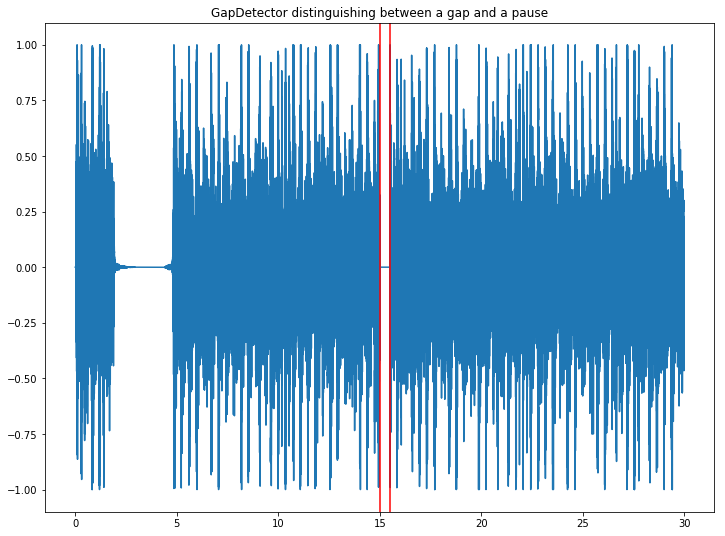

In [39]:
starts, ends = compute(audio)

times = np.linspace(0, len(audio) / fs, len(audio))

plt.plot(times, audio)
plt.title('GapDetector distinguishing between a gap and a pause')
for s in starts:
    plt.axvline(s, color='r')
    
for e in ends:
    plt.axvline(e, color='r')

# The parameters
This algorithm has many parameters to adapt its behaviour.

- **silenceThreshold.** The considered silence level in order to detect the gaps candidates

- **minimumTime / maximumTime.** This parameter allows filtering the retrieved gaps by the duration

- **maximumTime / prepowerTime / prepowerThreshold.** This parameters configure the characteristics of the pre/post power regions.

The last example shows what happens when the pre/post power computation is deactivated (via setting a very low threshold)

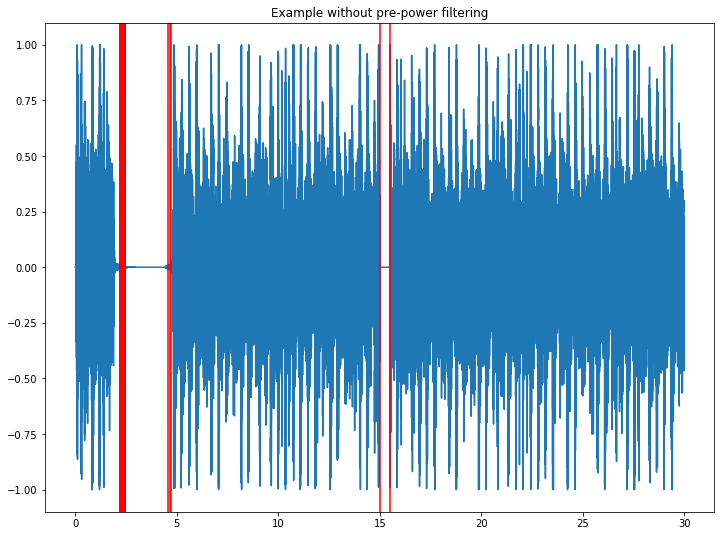

In [40]:
starts, ends = compute(audio, prepowerThreshold=-90)

times = np.linspace(0, len(audio) / fs, len(audio))

plt.plot(times, audio)
plt.title('Example without pre-power filtering')
for s in starts:
    plt.axvline(s, color='r')
    
for e in ends:
    plt.axvline(e, color='r')